In [1]:
import matplotlib.pyplot as plt
from matplotlib.container import BarContainer
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from collections import defaultdict
from os import listdir
import os
import matplotlib.patches as mpatches
import json

from plot_utils import *

In [2]:
DATASET = "EventsAdapt"
TASKSET = "MAIN" # "SI" "MAIN"

In [3]:
if TASKSET == "MAIN":
    task_order = ['logprobs',
                  'sentence_comparison',
                  'sentence_comparison_metaInstruct',
                  'sentence_judge_generation_likert',
                  'sentence_judge']
elif TASKSET == "SI":
    task_order = ['logprobs',
                   'sentence_judge_generation_likert']
    FREE_CONSTRAINED_SEPARATED = True
    

BETTER_TASK_NAMES = {
    'logprobs' : "Log Likelihood",
    'sentence_comparison' : 'Sentence Choice I',
    'sentence_comparison_metaInstruct' : 'Sentence Choice II',
    'sentence_judge_generation_likert' : 'Likert Scoring',
    'sentence_judge' : 'Sentence Judgment'
}

In [4]:
MODEL_LIST = [elm for elm in PRETTYNAMES.keys() if elm != "human"]

In [10]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "" #gets rid of horizontal lines
                }
sns.set_theme(font_scale=1.4, style="white", rc=custom_params)

In [11]:
def read_data(folder):
    task = folder.split("/")[-1]
    all_data = []
    
    # Get list of all JSON results files in the folder.
    files_to_read = [f for f in listdir(folder) if f.endswith(".json")]

    # Read each file into a single dataframe.
    for f in files_to_read:
        # Subset for current dataset!
        if not DATASET in f:
            continue
        with open(folder + "/" + f, "r") as fp:
            data = json.load(fp)
        results = pd.DataFrame(data["results"])
        for k, v in data["meta"].items():
            if not isinstance(v, list):
                results[k] = v
        results["corpus"] = f.split("_")[0]
        results["model"] = f.split("_")[1]
        results["task"] = task
        if not "comparison" in task:
            results["option_order"] = "noOrder"
        if task == "sentence_comparison":
            results["query"] = " ".join(f.split("q=")[1].split("_")[0].split("+"))
        all_data.append(results)

    if all_data == []:
        print(f"No models computed on benchmark {folder} yet!")
        return
    df = pd.concat(all_data)
    return df

In [12]:
# Read results for all tasks.
RESULT_DIR = f"../results"
TASKS = []
for dir_name in os.listdir(RESULT_DIR):
    TASKS.append(dir_name)
TASKS

['2023_results_prompting',
 'logprob_critical_word',
 'logprobs',
 'logprobs_critical_word',
 'sentence_comparison',
 'sentence_comparison_generation_1vs2',
 'sentence_judge',
 'sentence_judge_generation_likert',
 'word_comparison']

In [13]:
RESULTS = {task: read_data(f"{RESULT_DIR}/{task}") for task in TASKS}
RESULTS

No models computed on benchmark ../results/2023_results_prompting yet!
No models computed on benchmark ../results/logprob_critical_word yet!
No models computed on benchmark ../results/logprobs_critical_word yet!
No models computed on benchmark ../results/sentence_comparison_generation_1vs2 yet!
No models computed on benchmark ../results/word_comparison yet!


{'2023_results_prompting': None,
 'logprob_critical_word': None,
 'logprobs':      item_id                                      good_sentence  \
 0          1                     The raider caught the illness.   
 1          2              The illness was caught by the raider.   
 2          3               The marauder contracted the disease.   
 3          4        The disease was contracted by the marauder.   
 4          5                    The convict dreaded the prison.   
 ..       ...                                                ...   
 509      510  The abused woman was comforted by the social w...   
 510      511  The neuroscientist overwhelmed the lab assistant.   
 511      512  The lab assistant was overwhelmed by the neuro...   
 512      513             The warmonger terrorized the gunsmith.   
 513      514      The gunsmith was terrorized by the warmonger.   
 
                                           bad_sentence  \
 0                       The illness caught th

In [9]:
RESULTS.keys()

dict_keys(['2023_results_prompting', 'logprob_critical_word', 'logprobs', 'logprobs_critical_word', 'sentence_comparison', 'sentence_comparison_generation_1vs2', 'sentence_judge', 'sentence_judge_generation_likert', 'word_comparison'])

In [10]:
RESULTS["sentence_comparison"]

,item_id,prompt_good,good_sentence,bad_sentence,good_continuation,bad_continuation,logprob_of_good_cont,logprob_of_bad_cont,model,seed,eval_type,option_order,data_file,timestamp,corpus,task,query
0,1,You evaluating the plausibility of sentences. ...,The raider caught the illness.,The illness caught the raider.,2,1,-4.199170,-1.847540,Mistral-7B-Instruct-v0.1,1,metaInstruct,badFirst,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-13 03:43:51,EventsAdapt,sentence_comparison,is plausible
1,2,You evaluating the plausibility of sentences. ...,The illness was caught by the raider.,The raider was caught by the illness.,2,1,-4.219783,-1.892883,Mistral-7B-Instruct-v0.1,1,metaInstruct,badFirst,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-13 03:43:51,EventsAdapt,sentence_comparison,is plausible
2,3,You evaluating the plausibility of sentences. ...,The marauder contracted the disease.,The disease contracted the marauder.,2,1,-4.211889,-1.948141,Mistral-7B-Instruct-v0.1,1,metaInstruct,badFirst,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-13 03:43:51,EventsAdapt,sentence_comparison,is plausible
3,4,You evaluating the plausibility of sentences. ...,The disease was contracted by the marauder.,The marauder was contracted by the disease.,2,1,-4.424838,-2.023844,Mistral-7B-Instruct-v0.1,1,metaInstruct,badFirst,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-13 03:43:51,EventsAdapt,sentence_comparison,is plausible
4,5,You evaluating the plausibility of sentences. ...,The convict dreaded the prison.,The prison dreaded the convict.,2,1,-4.192657,-1.796208,Mistral-7B-Instruct-v0.1,1,metaInstruct,badFirst,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-13 03:43:51,EventsAdapt,sentence_comparison,is plausible
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,510,Here are two English sentences:\n\n1) The abus...,The abused woman was comforted by the social w...,The social worker was comforted by the abused ...,1,2,-0.961878,-1.467108,mpt-7b,1,metaQuestionComplex,goodFirst,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-13 03:38:04,EventsAdapt,sentence_comparison,is plausible
510,511,Here are two English sentences:\n\n1) The neur...,The neuroscientist overwhelmed the lab assistant.,The lab assistant overwhelmed the neuroscientist.,1,2,-1.022201,-1.464851,mpt-7b,1,metaQuestionComplex,goodFirst,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-13 03:38:04,EventsAdapt,sentence_comparison,is plausible
511,512,Here are two English sentences:\n\n1) The lab ...,The lab assistant was overwhelmed by the neuro...,The neuroscientist was overwhelmed by the lab ...,1,2,-0.946148,-1.449639,mpt-7b,1,metaQuestionComplex,goodFirst,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-13 03:38:04,EventsAdapt,sentence_comparison,is plausible
512,513,Here are two English sentences:\n\n1) The warm...,The warmonger terrorized the gunsmith.,The gunsmith terrorized the warmonger.,1,2,-0.964829,-1.495144,mpt-7b,1,metaQuestionComplex,goodFirst,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-13 03:38:04,EventsAdapt,sentence_comparison,is plausible


# Plot for one dataset logprobs vs. other metrics

In [11]:
import re
def extract_single_number(input_string):
    # Find all sequences of digits in the string
    numbers = re.findall(r'\d+', input_string)

    # Return the single number or None if there are multiple numbers
    return numbers[0] if len(numbers) == 1 else None

In [12]:
def preprocess_free_generation_dfs(free_df, task):
    filtered_df = free_df.copy()

    if task == "sentence_comparison_generation_1vs2":
        # subset to see if it contains continuation
        filtered_df = filtered_df[(filtered_df["contains_pattern"] == True)]
        filtered_df['generation'] = filtered_df['generation'].apply(extract_single_number)
        filtered_df = filtered_df[filtered_df['generation'].notna()]
    else:
        try:
            # subset to see if it contains continuation
            filtered_df = filtered_df[(filtered_df["bad_continuation_contains_pattern"] == True) & \
                                      (filtered_df["good_continuation_contains_pattern"] == True)]
            filtered_df['good_generation'] = filtered_df['good_generation'].apply(extract_single_number)
            filtered_df['bad_generation'] = filtered_df['bad_generation'].apply(extract_single_number)
            filtered_df = filtered_df[(filtered_df['good_generation'].notna()) & \
                                      (filtered_df['bad_generation'].notna())]
        except:
            filtered_df['good_generation'] = filtered_df['good_generation'].apply(extract_single_number)
            filtered_df['bad_generation'] = filtered_df['bad_generation'].apply(extract_single_number)
            filtered_df = filtered_df[(filtered_df['good_generation'].notna()) & \
                                      (filtered_df['bad_generation'].notna())]

    if len(filtered_df) == 0:
        print("WATCH OUT!! Filtering resulted in no values")
        
    return filtered_df

In [13]:
def compute_accuracy_metric(result_df, task):
    out_df = result_df.copy()
    initial_length = len(out_df)
    # Drop empty columns
    out_df = out_df.dropna(axis=1, how='all')
    # Drop empty rows
    out_df = out_df.dropna(axis=0, how='all')
    after_drop_length = len(out_df)
    if initial_length - after_drop_length != 0:
        print(f"Dropped {initial_length - after_drop_length} rows with NA values")

    # Balanced accuracy: (TPR+TNR)/2
    def _balanced_accuracy(rows):
        tp = rows.model_prefers_yes_good.mean()
        tn = rows.model_prefers_no_bad.mean()
        return np.mean([tp, tn])
    
    if task == "logprobs":
        out_df["Accuracy"] = out_df.apply(
            lambda row: 1 if row.logprob_of_good_sentence > row.logprob_of_bad_sentence else 0, axis=1)

    elif task == "logprobs_cricital_word":
        raise NotImplementedError("Not for this task")
    
    elif task == "sentence_judge": #continuation here is "yes"/"no"
        # True positive
        out_df["model_prefers_yes_good"] = out_df.apply(
            lambda row: row.logprob_of_yes_good_sentence > row.logprob_of_no_good_sentence,
            axis=1
        )
        # True negative
        out_df["model_prefers_no_bad"] = out_df.apply(
            lambda row: row.logprob_of_no_bad_sentence > row.logprob_of_yes_bad_sentence,
            axis=1
        )
        # False positive
        out_df["model_prefers_yes_bad"] = out_df.apply(
            lambda row: row.logprob_of_yes_bad_sentence > row.logprob_of_no_bad_sentence,
            axis=1
        )
        # False negative
        out_df["model_prefers_no_good"] = out_df.apply(
            lambda row: row.logprob_of_no_good_sentence > row.logprob_of_yes_good_sentence,
            axis=1
        )

        out_df["Accuracy"] = out_df.apply(
            lambda row: 1 if ((row.model_prefers_yes_good == 1) & (row.model_prefers_no_bad == 1)) else 0, axis=1)
        

    elif task == "sentence_comparison": #continuation here is "1"/"2" #note I messed up here with the task;
        # that's why the two cases, fix this in the jsons
        try:
            out_df["Accuracy"] = out_df.apply(
                lambda row: 1 if row.logprob_of_good_continuation > row.logprob_of_bad_continuation else 0, axis=1)
        except:
            out_df["Accuracy"] = out_df.apply(
                lambda row: 1 if row.logprob_of_good_cont > row.logprob_of_bad_cont else 0, axis=1)

    elif task == "sentence_comparison_generation_1vs2":
        if "free" in out_df.gen_type.unique():
            free_df = out_df[out_df.gen_type == "free"]
            free_df = preprocess_free_generation_dfs(free_df, task)
            constrained_df = out_df[out_df.gen_type == "constrained"]
            out_df = pd.concat([free_df, constrained_df])
        if len(out_df) == 0:
            print("Filtering resulted in no values")
        else:
            out_df["Accuracy"] = out_df.apply(
                lambda row: 1 if row.generation == row.good_sentence_nr else 0, axis=1)

    elif task == "sentence_judge_generation_likert":
        if "free" in out_df.gen_type.unique():
            free_df = out_df[out_df.gen_type == "free"]
            free_df = preprocess_free_generation_dfs(free_df, task)
            constrained_df = out_df[out_df.gen_type == "constrained"]
            out_df = pd.concat([free_df, constrained_df])
        if len(out_df) == 0:
            print("Filtering resulted in no values")
        else:
            out_df["Accuracy"] = out_df.apply(
                lambda row: 1 if row.good_generation > row.bad_generation else 0, axis=1)

    elif task == "word_comparison":
        out_df["Accuracy"] = out_df.apply(
                lambda row: 1 if row.logprob_of_good_cont > row.logprob_of_bad_cont else 0, axis=1)

    else:
        raise ValueError("Not implemented")
    
    return out_df

In [14]:
df_list = []
for task, result_df in RESULTS.items():
    if not task in task_order:
        continue
    if result_df is None:
        continue
    print(task)
    result_df = result_df[result_df.corpus == DATASET]  #subset for dataset here
    result_df = result_df[result_df.model.isin(MODEL_LIST)]  #subset for models here
    if len(result_df) == 0:
        print(f"{DATASET} was not computed for task {task} yet")
        continue
    out_df = compute_accuracy_metric(result_df, task)
    df_list.append(out_df)
    print("****")

logprobs
****
sentence_comparison
****
sentence_judge
****
sentence_judge_generation_likert
****


In [15]:
df_list
full_df = pd.concat(df_list)

In [16]:
full_df

,item_id,good_sentence,bad_sentence,logprob_of_good_sentence,logprob_of_bad_sentence,num_tokens_good_sentence,num_tokens_bad_sentence,model,seed,eval_type,...,logprob_of_no_bad_sentence,model_prefers_yes_good,model_prefers_no_bad,model_prefers_yes_bad,model_prefers_no_good,good_prompt,bad_prompt,good_generation,bad_generation,gen_type
0,1,The raider caught the illness.,The illness caught the raider.,-80.383024,-83.095198,10.0,10.0,Mistral-7B-Instruct-v0.1,1,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,The illness was caught by the raider.,The raider was caught by the illness.,-80.226654,-79.479498,12.0,12.0,Mistral-7B-Instruct-v0.1,1,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,The marauder contracted the disease.,The disease contracted the marauder.,-80.572105,-82.279467,12.0,12.0,Mistral-7B-Instruct-v0.1,1,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,The disease was contracted by the marauder.,The marauder was contracted by the disease.,-78.742416,-87.866671,14.0,14.0,Mistral-7B-Instruct-v0.1,1,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,The convict dreaded the prison.,The prison dreaded the convict.,-84.144069,-83.048722,11.0,11.0,Mistral-7B-Instruct-v0.1,1,direct,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,510,The abused woman was comforted by the social w...,The social worker was comforted by the abused ...,NaN,NaN,NaN,NaN,mpt-7b,1,NaN,...,NaN,NaN,NaN,NaN,NaN,You will be given a sentence. Your task is to ...,You will be given a sentence. Your task is to ...,5,5,constrained
510,511,The neuroscientist overwhelmed the lab assistant.,The lab assistant overwhelmed the neuroscientist.,NaN,NaN,NaN,NaN,mpt-7b,1,NaN,...,NaN,NaN,NaN,NaN,NaN,You will be given a sentence. Your task is to ...,You will be given a sentence. Your task is to ...,5,6,constrained
511,512,The lab assistant was overwhelmed by the neuro...,The neuroscientist was overwhelmed by the lab ...,NaN,NaN,NaN,NaN,mpt-7b,1,NaN,...,NaN,NaN,NaN,NaN,NaN,You will be given a sentence. Your task is to ...,You will be given a sentence. Your task is to ...,3,4,constrained
512,513,The warmonger terrorized the gunsmith.,The gunsmith terrorized the warmonger.,NaN,NaN,NaN,NaN,mpt-7b,1,NaN,...,NaN,NaN,NaN,NaN,NaN,You will be given a sentence. Your task is to ...,You will be given a sentence. Your task is to ...,4,5,constrained


In [17]:
# Drop seed = 0, No difference
if TASKSET != "SI":
    full_df = full_df.loc[full_df["seed"] != 0]

In [18]:
full_df['eval_type'] = full_df['eval_type'].fillna(full_df['task'])
#Get metaInstruct results
not_nan_mask = full_df["eval_type"] == "metaInstruct"
full_df.loc[not_nan_mask, "task"] = full_df.loc[not_nan_mask, "task"] + "_" + full_df.loc[not_nan_mask, "eval_type"]
if 'query' in full_df:
    full_df['query'] = full_df['query'].fillna("direct")
if 'gen_type' in full_df:
    full_df['gen_type'] = full_df['gen_type'].fillna("direct")
    levels = ["corpus", "model", "task", "eval_type", "gen_type", "query", "option_order", "seed"]
else:
    levels = ["corpus", "model", "task", "eval_type", "option_order", "seed"]

/tmp/ipykernel_2588090/4219396895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['eval_type'] = full_df['eval_type'].fillna(full_df['task'])
/tmp/ipykernel_2588090/4219396895.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['query'] = full_df['query'].fillna("direct")
/tmp/ipykernel_2588090/4219396895.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

# Load sentence information

In [19]:
import os
data_path = os.path.abspath('../datasets/single_sentences/EventsAdapt/corpus.csv')
eventsAdapt_df = pd.read_csv(data_path)
eventsAdapt_df.head()

,item_id,good_sentence,bad_sentence,good_human_score,bad_human_score,trial_type,voice
0,1,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active
1,2,The illness was caught by the raider.,The raider was caught by the illness.,5.333333,2.541667,AI,passive
2,3,The marauder contracted the disease.,The disease contracted the marauder.,5.680000,1.440000,AI,active
3,4,The disease was contracted by the marauder.,The marauder was contracted by the disease.,5.875000,1.818182,AI,passive
4,5,The convict dreaded the prison.,The prison dreaded the convict.,6.208333,4.318182,AI,active


In [20]:
full_df = eventsAdapt_df.merge(full_df, on = ["good_sentence", "bad_sentence"])
full_df

,item_id_x,good_sentence,bad_sentence,good_human_score,bad_human_score,trial_type,voice,item_id_y,logprob_of_good_sentence,logprob_of_bad_sentence,...,logprob_of_no_bad_sentence,model_prefers_yes_good,model_prefers_no_bad,model_prefers_yes_bad,model_prefers_no_good,good_prompt,bad_prompt,good_generation,bad_generation,gen_type
0,1,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1,-80.383024,-83.095198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,direct
1,1,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1,-85.420685,-84.774742,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,direct
2,1,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1,-50.871655,-45.857755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,direct
3,1,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1,-45.142372,-45.505023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,direct
4,1,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1,-55.528430,-61.421805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,direct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25181,514,The gunsmith was terrorized by the warmonger.,The warmonger was terrorized by the gunsmith.,4.772727,4.700000,AAN,passive,514,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,You will be given a sentence. Your task is to ...,You will be given a sentence. Your task is to ...,7,6,constrained
25182,514,The gunsmith was terrorized by the warmonger.,The warmonger was terrorized by the gunsmith.,4.772727,4.700000,AAN,passive,514,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,You will be given a sentence. Your task is to ...,You will be given a sentence. Your task is to ...,7,1,constrained
25183,514,The gunsmith was terrorized by the warmonger.,The warmonger was terrorized by the gunsmith.,4.772727,4.700000,AAN,passive,514,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,You will be given a sentence. Your task is to ...,You will be given a sentence. Your task is to ...,1,1,constrained
25184,514,The gunsmith was terrorized by the warmonger.,The warmonger was terrorized by the gunsmith.,4.772727,4.700000,AAN,passive,514,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,You will be given a sentence. Your task is to ...,You will be given a sentence. Your task is to ...,3,6,constrained


In [21]:
# Check if "trial_type" is not NaN
not_nan_mask = ~full_df["trial_type"].isna()
# Concatenate "corpus" and "trial_type" columns for non-NaN rows
full_df.loc[not_nan_mask, "corpus"] = full_df.loc[not_nan_mask, "corpus"] + "_" + full_df.loc[not_nan_mask, "trial_type"]
full_df

,item_id_x,good_sentence,bad_sentence,good_human_score,bad_human_score,trial_type,voice,item_id_y,logprob_of_good_sentence,logprob_of_bad_sentence,...,logprob_of_no_bad_sentence,model_prefers_yes_good,model_prefers_no_bad,model_prefers_yes_bad,model_prefers_no_good,good_prompt,bad_prompt,good_generation,bad_generation,gen_type
0,1,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1,-80.383024,-83.095198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,direct
1,1,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1,-85.420685,-84.774742,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,direct
2,1,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1,-50.871655,-45.857755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,direct
3,1,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1,-45.142372,-45.505023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,direct
4,1,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1,-55.528430,-61.421805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,direct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25181,514,The gunsmith was terrorized by the warmonger.,The warmonger was terrorized by the gunsmith.,4.772727,4.700000,AAN,passive,514,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,You will be given a sentence. Your task is to ...,You will be given a sentence. Your task is to ...,7,6,constrained
25182,514,The gunsmith was terrorized by the warmonger.,The warmonger was terrorized by the gunsmith.,4.772727,4.700000,AAN,passive,514,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,You will be given a sentence. Your task is to ...,You will be given a sentence. Your task is to ...,7,1,constrained
25183,514,The gunsmith was terrorized by the warmonger.,The warmonger was terrorized by the gunsmith.,4.772727,4.700000,AAN,passive,514,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,You will be given a sentence. Your task is to ...,You will be given a sentence. Your task is to ...,1,1,constrained
25184,514,The gunsmith was terrorized by the warmonger.,The warmonger was terrorized by the gunsmith.,4.772727,4.700000,AAN,passive,514,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,You will be given a sentence. Your task is to ...,You will be given a sentence. Your task is to ...,3,6,constrained


In [22]:
# check
grouped = full_df.groupby(levels)["Accuracy"].mean().reset_index()
grouped

,corpus,model,task,eval_type,gen_type,query,option_order,seed,Accuracy
0,EventsAdapt_AAN,Mistral-7B-Instruct-v0.1,logprobs,direct,direct,direct,noOrder,1,0.728682
1,EventsAdapt_AAN,Mistral-7B-Instruct-v0.1,sentence_comparison,metaQuestionComplex,direct,is plausible,badFirst,1,0.806202
2,EventsAdapt_AAN,Mistral-7B-Instruct-v0.1,sentence_comparison,metaQuestionComplex,direct,is plausible,goodFirst,1,0.883721
3,EventsAdapt_AAN,Mistral-7B-Instruct-v0.1,sentence_comparison_metaInstruct,metaInstruct,direct,is plausible,badFirst,1,0.000000
4,EventsAdapt_AAN,Mistral-7B-Instruct-v0.1,sentence_comparison_metaInstruct,metaInstruct,direct,is plausible,goodFirst,1,1.000000
...,...,...,...,...,...,...,...,...,...
93,EventsAdapt_AI,mpt-7b-instruct,sentence_comparison,metaQuestionComplex,direct,is plausible,goodFirst,1,0.828125
94,EventsAdapt_AI,mpt-7b-instruct,sentence_comparison_metaInstruct,metaInstruct,direct,is plausible,badFirst,1,0.000000
95,EventsAdapt_AI,mpt-7b-instruct,sentence_comparison_metaInstruct,metaInstruct,direct,is plausible,goodFirst,1,1.000000
96,EventsAdapt_AI,mpt-7b-instruct,sentence_judge,metaQuestionComplex,direct,direct,noOrder,1,0.320312


In [23]:
# exclude levels "option_order", "seed"
levels = [elm for elm in levels if elm not in ["option_order", "seed"]]

In [24]:
for t in grouped.task.unique():
    print(t.upper())
    sub_df = grouped.loc[grouped["task"] == t]
    print(sub_df)
    print(f"Length: {len(sub_df)}")
    print("*****")

LOGPROBS
             corpus                     model      task eval_type gen_type  \
0   EventsAdapt_AAN  Mistral-7B-Instruct-v0.1  logprobs    direct   direct   
7   EventsAdapt_AAN           Mistral-7B-v0.1  logprobs    direct   direct   
14  EventsAdapt_AAN                 falcon-7b  logprobs    direct   direct   
21  EventsAdapt_AAN        falcon-7b-instruct  logprobs    direct   direct   
28  EventsAdapt_AAN                   gpt2-xl  logprobs    direct   direct   
35  EventsAdapt_AAN                    mpt-7b  logprobs    direct   direct   
42  EventsAdapt_AAN           mpt-7b-instruct  logprobs    direct   direct   
49   EventsAdapt_AI  Mistral-7B-Instruct-v0.1  logprobs    direct   direct   
56   EventsAdapt_AI           Mistral-7B-v0.1  logprobs    direct   direct   
63   EventsAdapt_AI                 falcon-7b  logprobs    direct   direct   
70   EventsAdapt_AI        falcon-7b-instruct  logprobs    direct   direct   
77   EventsAdapt_AI                   gpt2-xl  logprobs

# PLOT

In [25]:
full_df.task.unique()

array(['logprobs', 'sentence_comparison_metaInstruct',
       'sentence_comparison', 'sentence_judge',
       'sentence_judge_generation_likert'], dtype=object)

In [26]:
## NEW

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

plot_df = full_df[["corpus", "model", "task", "Accuracy"]]

plot_df['model'] = pd.Categorical(plot_df['model'], categories=MODEL_LIST, ordered=True)
if TASKSET == "MAIN":
    to = [elm for elm in task_order if elm in list(plot_df.task)]
    # Subset for tasks
    plot_df = plot_df.loc[plot_df.task.isin(task_order)]
    plot_df['task'] = pd.Categorical(plot_df['task'], categories=to, ordered=True)
plot_df

/tmp/ipykernel_2588090/1984648106.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['model'] = pd.Categorical(plot_df['model'], categories=MODEL_LIST, ordered=True)


,corpus,model,task,Accuracy
0,EventsAdapt_AI,Mistral-7B-Instruct-v0.1,logprobs,1
1,EventsAdapt_AI,Mistral-7B-v0.1,logprobs,0
2,EventsAdapt_AI,falcon-7b-instruct,logprobs,0
3,EventsAdapt_AI,falcon-7b,logprobs,1
4,EventsAdapt_AI,gpt2-xl,logprobs,1
...,...,...,...,...
25181,EventsAdapt_AAN,falcon-7b-instruct,sentence_judge_generation_likert,1
25182,EventsAdapt_AAN,falcon-7b,sentence_judge_generation_likert,1
25183,EventsAdapt_AAN,gpt2-xl,sentence_judge_generation_likert,0
25184,EventsAdapt_AAN,mpt-7b-instruct,sentence_judge_generation_likert,0


In [34]:
# delete again
show_df = plot_df.groupby(["corpus", "model", "task"])["Accuracy"].agg(['mean', 'sem']).reset_index()
show_df['task_renamed'] = show_df.apply(lambda row: BETTER_TASK_NAMES[row.task], axis=1)
# Round mean and sem to 2 decimal places
show_df = show_df.round({'mean': 2, 'sem': 2})
show_df.to_csv(f"show_mean_sem_{DATASET}.{TASKSET}.csv")

In [33]:
plot_df.task.unique()

['logprobs', 'sentence_comparison_metaInstruct', 'sentence_comparison', 'sentence_judge', 'sentence_judge_generation_likert']
Categories (5, object): ['logprobs' < 'sentence_comparison' < 'sentence_comparison_metaInstruct' < 'sentence_judge_generation_likert' < 'sentence_judge']

In [29]:
plot_df.to_csv(f"{DATASET}.{TASKSET}.csv")

In [30]:
# Add human data
human_data_path = os.path.abspath(f'../datasets/single_sentences/EventsAdapt/corpus.csv')
human_df = pd.read_csv(human_data_path)
human_df["corpus"] = "EventsAdapt"
human_df["corpus"] = human_df["corpus"] + "_" + human_df["trial_type"]
human_df["Accuracy"] = human_df.apply(
            lambda row: 1 if row.good_human_score > row.bad_human_score else 0, axis=1)

human_df.to_csv(f"{DATASET}.{TASKSET}.human.csv")

# get vals
human_values = human_df.groupby("corpus")["Accuracy"].agg(['mean', 'sem']).reset_index()
human_values.columns = ['corpus', 'Mean_Accuracy', 'SEM_Accuracy']
human_values

,corpus,Mean_Accuracy,SEM_Accuracy
0,EventsAdapt_AAN,0.957364,0.012603
1,EventsAdapt_AI,0.992188,0.005513


/tmp/ipykernel_16083/2828056429.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels = new_labels, rotation=0, fontweight='normal')


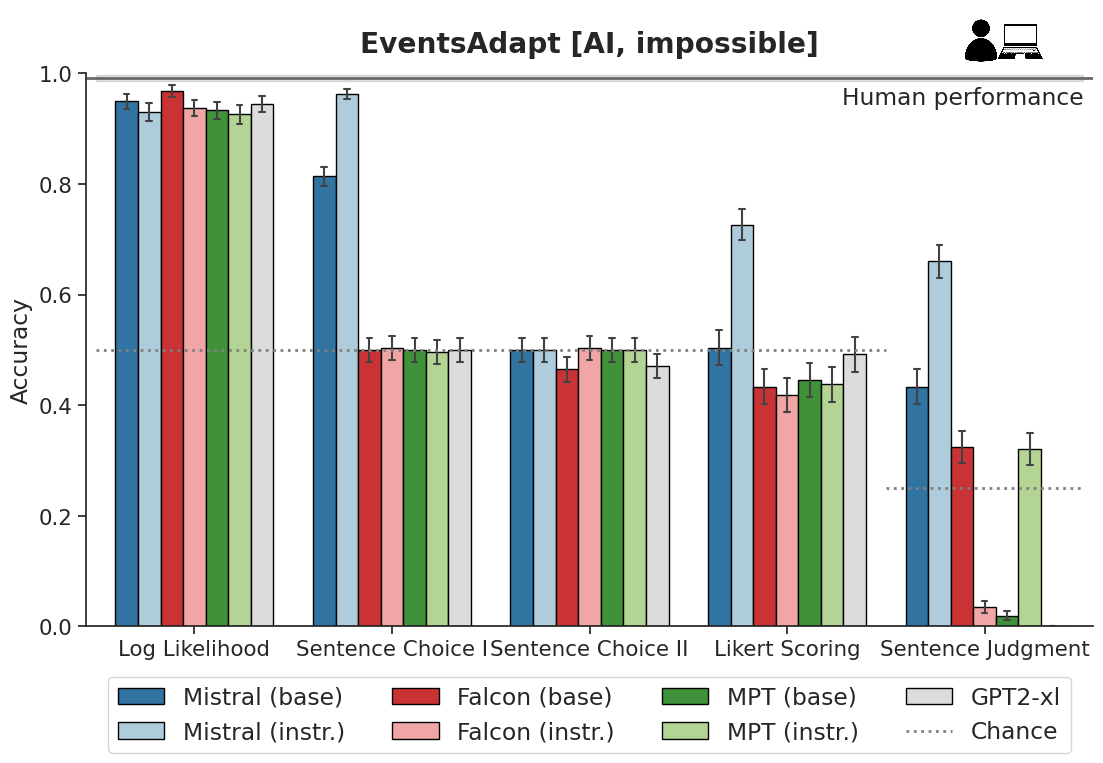

/tmp/ipykernel_16083/2828056429.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels = new_labels, rotation=0, fontweight='normal')


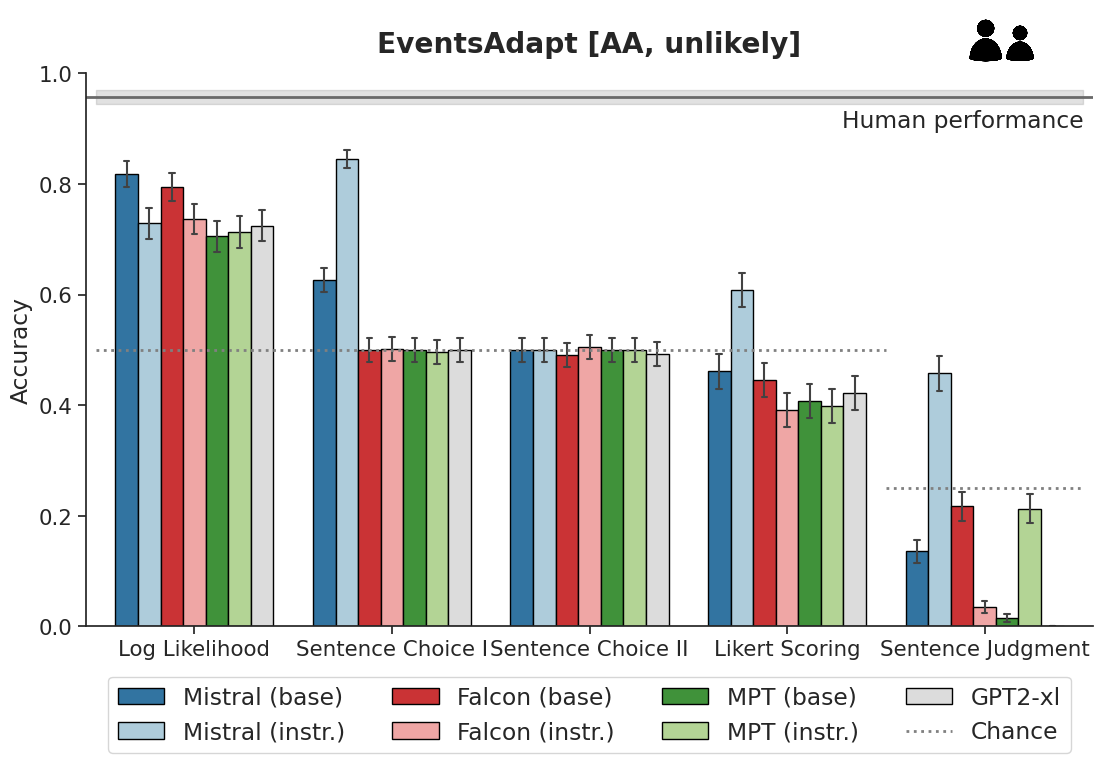

In [31]:
for corpus in plot_df.corpus.unique():
    curr_df = plot_df.loc[plot_df.corpus == corpus]

    plt.figure(figsize=(13, 7))
    
    ax = sns.barplot(data=curr_df, x="task", y="Accuracy", hue="model", edgecolor='black', linewidth=1, errorbar="se",
                     palette=MODEL_PAL, capsize=0.2, err_kws={'linewidth': 1.5})
    
    # Extract text from each Text object
    xticklabels = [label.get_text() for label in ax.get_xticklabels()]
    
    new_labels = []
    for task in xticklabels:
        new_labels.append(BETTER_TASK_NAMES[task])
    
    ax.set_xticklabels(labels = new_labels, rotation=0, fontweight='normal')
    ax.set_xlabel("")
    
    # add chance level lines
    x_range = ax.get_xlim()
    if "sentence_judge" in xticklabels:
        # Plot a dotted line at height 0.5
        ax.plot([x_range[0] , x_range[1] - 1], [0.5, 0.5], linestyle=":", color="gray", alpha=1, linewidth=2, label="Chance")
        # Plot a dotted line at height 0.25
        ax.plot([x_range[1] - 1 , x_range[1]], [0.25, 0.25], linestyle=":", color="gray", alpha=1, linewidth=2)
    else:
        ax.axhline(y=0.5, linestyle=":", color="gray", alpha=1, linewidth=2, label="Chance")

    human_baseline = human_values.loc[human_values.corpus == corpus].Mean_Accuracy.item()
    human_error = human_values.loc[human_values.corpus == corpus].SEM_Accuracy.item()

    # Calculate the y-range for the shaded area
    ymin = human_baseline - human_error
    ymax = human_baseline + human_error
    # Add shaded error around the horizontal line
    ax.fill_betweenx(y=[ymin, ymax], x1=x_range[0], x2=x_range[1], color=MODEL_PAL["human"], alpha=0.2)
    ax.axhline(y=human_baseline, linestyle="-", color=MODEL_PAL["human"], alpha=1, linewidth=2) #, label="human")
    ax.text(x_range[1], ymin - 0.01, "Human performance", verticalalignment='top', horizontalalignment='right')
    
    # Fix ylim
    plt.ylim(0,1)
    
    
    # Add title
    # Load the icon image
    aa_icon_path = 'animate-animate.png'
    ai_icon_path = 'animate-inanimate-laptop.png'
    
    # Define the properties of the bounding box
    bbox_props = dict(boxstyle="round,pad=0.3", ec="black", lw=1, facecolor="white", alpha=0.7)

    RENAME_DATS = {
    "EventsAdapt_AI" : "EventsAdapt [AI, impossible]",
    "EventsAdapt_AAN" : "EventsAdapt [AA, unlikely]"
    }
    
    ax.set_title(RENAME_DATS[corpus], fontweight='bold', fontsize="large", pad=15)

    if "AI" in corpus:
        icon = mpimg.imread(ai_icon_path)
    else:
        icon = mpimg.imread(aa_icon_path)
    
    # Create an offset image
    imagebox = OffsetImage(icon, zoom=0.03)
    imagebox.image.axes = ax
    
    # Create an AnnotationBbox
    ab = AnnotationBbox(imagebox, (0.91, 1.06), xycoords='axes fraction', frameon=False)
    
    # Add the icon to the subplot
    ax.add_artist(ab)
    
    # Style and add legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [PRETTYNAMES[elm] if elm in PRETTYNAMES else elm for elm in labels]

    ax.legend(handles, new_labels, loc='lower center', bbox_to_anchor=(0.5, -0.25),
              ncol=4, frameon=True, fontsize='medium')
    
    plt.margins(x=0.01)
        
    # Adjust the layout and display the plot
    plt.subplots_adjust(top=0.9)  # Adjust the top of the subplots for the suptitle
    
    
    if TASKSET == "SI":
        plt.savefig(f'figures/PromptChoice.{DATASET}.{corpus}.generation.freeVsConstrained.png', dpi=280, bbox_inches="tight")
    else:
        plt.savefig(f'figures/PromptChoice.{DATASET}.{corpus}.svg', dpi=280, bbox_inches="tight")
        plt.savefig(f'figures/PromptChoice.{DATASET}.{corpus}.png', dpi=280, bbox_inches="tight")
    
    plt.show()

In [30]:
from scipy.stats import binomtest, chi2_contingency
from statsmodels.stats.multitest import multipletests

def assign_significance_labels(pvals):
    return ["***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "n.s." for p in pvals]

def calculate_binom_pval(num_correct, num_total, task):
    if task == "sentence_judge":
        p=0.25
    else:
        p=0.5
    return binomtest(k=num_correct, n=num_total, p=p).pvalue

for task in task_order:
    print(task.upper())
    sub_df = curr_df.loc[curr_df["task"] == task]
    if sub_df is None:
        continue
        # Calculate p-values for binomial test
    dat_binchoice_summary = sub_df.groupby('model').agg(NumCorrect=('Accuracy', 'sum'), NumTotal=('Accuracy', 'count')) \
        .reset_index() \
        .assign(AccuracyScore=lambda x: x['NumCorrect'] / x['NumTotal'])

    dat_binchoice_summary['pVal'] = dat_binchoice_summary.apply(lambda row: calculate_binom_pval(row['NumCorrect'], row['NumTotal'], task), axis=1)
    dat_binchoice_summary['pValAdjusted'] = multipletests(dat_binchoice_summary['pVal'], method='fdr_bh')[1]
    dat_binchoice_summary['significance'] = assign_significance_labels(dat_binchoice_summary['pValAdjusted'])
    print(dat_binchoice_summary)
    print("\n\n")

LOGPROBS
                      model  NumCorrect  NumTotal  AccuracyScore  \
0           Mistral-7B-v0.1         211       258       0.817829   
1  Mistral-7B-Instruct-v0.1         188       258       0.728682   
2                 falcon-7b         205       258       0.794574   
3        falcon-7b-instruct         190       258       0.736434   
4                    mpt-7b         182       258       0.705426   
5           mpt-7b-instruct         184       258       0.713178   
6                   gpt2-xl         187       258       0.724806   

           pVal  pValAdjusted significance  
0  5.453388e-26  3.817372e-25          ***  
1  1.200251e-13  2.100439e-13          ***  
2  2.837759e-22  9.932156e-22          ***  
3  1.579396e-14  3.685257e-14          ***  
4  3.336666e-11  3.336666e-11          ***  
5  5.509232e-12  6.427438e-12          ***  
6  3.214249e-13  4.499948e-13          ***  



SENTENCE_COMPARISON
                      model  NumCorrect  NumTotal  AccuracyScor